# ARIM-Academy：　機器データ利活用ユースケース
### タイトル：機械学習支援によるプロセス設計：限られた実験データを用いたマイクロ波アシスト型アンモニア合成
### 機器：マイクロ波合成装置（ガス反応）
### 分析：SMOTEによるオーバーサンプリング

### データセット

この実験データセットは、マイクロ波を使ったアンモニア合成反応に関する46回の試験結果をまとめたものです【1】。データは、以下の5つの変数から構成されており、CSV形式で「data_full.csv」に保存されています。

1. **反応温度 [K]**  
2. **圧力 [psig]**  
3. **供給流量**  
4. **水素と窒素の比**  
5. **アンモニア濃度 [%]**

また、簡易版データセットとして、「圧力」、「水素と窒素の比」、「アンモニア濃度」の3項目に絞った35回分のデータからなる実験を「data.csv」として保存されています。

試験データが少ないため、このままでは機械学習モデルの学習が難しくなります。そのため、データを増やすために**SMOTE (Synthetic Minority Over-sampling Technique)** という手法を使います。

**SMOTE**は、不均衡なデータセットにおいて、データが少ないクラスを増やすためのオーバーサンプリング技術です。この方法では、少数クラスのデータが不足している場合、似たような特徴を持つデータを生成することで、クラス間のデータ数をバランスさせます。これにより、モデルが偏りなく学習しやすくなり、性能の向上が期待できます。

---

【1】Masud MAA, Araia A, Wang Y, Hu J, Tian Y. Machine learning-aided process design using limited experimental data: A microwave-assisted ammonia synthesis case study. *AIChE Journal*. 2024; e18621. doi:10.1002/aic.18621

### コードへの接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [ ]:
!pip install pip install imbalanced-learn
!git clone https://github.com/ARIM_ProcessInformatics/Example_1.git
%cd Example_1

### ライブラリのインポート
コード実行で必要なpythonのライブラリをimport文でロードします。

In [1]:
#汎用ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objects as go

# SMOTE
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# 1. データの準備
### サンプルファイルの読み込み
pandasライブラリの`read_csv()`関数は、csvファイルを読み込んでpandasのDataFrame形式に変換する関数です。ここでは[data]フォルダーにあるdata.csvファイルをDataFrameとして読み込み、その結果をdfという変数に格納します。

In [2]:
# CSVファイルからデータを読み込む
df = pd.read_csv('./data/data.csv')
df

Pressure(psig)  H2 to N2 ratio  Ammonia Concentration(%)
0             0.00             0.5                      0.36
1            20.49             0.5                      0.69
2            39.18             0.5                      0.96
3            59.59             0.5                      1.21
4            79.93             0.5                      1.43
5             0.00             1.0                      0.58
6            10.24             1.0                      0.79
7            20.11             1.0                      0.96
8            39.33             1.0                      1.23
9            59.44             1.0                      1.44
10           75.44             1.0                      1.55
11           79.85             1.0                      1.57
12            0.00             2.0                      0.60
13           10.09             2.0                      0.78
14           20.41             2.0                      0.94
15           39.18             2.0                      1.15
16           59.51             2.0                      1.29
17           75.59             2.0                      1.34
18           80.00             2.0                      1.34
19            0.00             3.0                      0.61
20           10.32             3.0                      0.71
21           20.56             3.0                      0.79
22           39.18             3.0                      0.91
23           59.44             3.0                      1.00
24           79.85             3.0                      1.03
25            0.00             5.0                      0.51
26           10.32             5.0                      0.56
27           20.49             5.0                      0.59
28           39.33             5.0                      0.65
29           59.66             5.0                      0.67
30           79.85             5.0                      0.68
31           80.00             1.0                      1.57
32           80.00             1.0                      1.16
33           80.00             1.0                      1.02
34           80.00             1.0                      1.89

### 重複データの削除
ここでは、'H2 to N2 ratio' と 'Ammonia Concentration(%)' の列を基準に重複行を`drop_duplicates()`メソッドを使って削除し、重複のないデータセットを df_unique として保存します。（dfでは重複がないため、df_uniqueはdfと同一となります）

In [3]:
# 特徴量に基づいて重複行を削除
df_unique = df.drop_duplicates(subset=['H2 to N2 ratio', 'Ammonia Concentration(%)'])
df_unique 

Pressure(psig)  H2 to N2 ratio  Ammonia Concentration(%)
0             0.00             0.5                      0.36
1            20.49             0.5                      0.69
2            39.18             0.5                      0.96
3            59.59             0.5                      1.21
4            79.93             0.5                      1.43
5             0.00             1.0                      0.58
6            10.24             1.0                      0.79
7            20.11             1.0                      0.96
8            39.33             1.0                      1.23
9            59.44             1.0                      1.44
10           75.44             1.0                      1.55
11           79.85             1.0                      1.57
12            0.00             2.0                      0.60
13           10.09             2.0                      0.78
14           20.41             2.0                      0.94
15           39.18             2.0                      1.15
16           59.51             2.0                      1.29
17           75.59             2.0                      1.34
19            0.00             3.0                      0.61
20           10.32             3.0                      0.71
21           20.56             3.0                      0.79
22           39.18             3.0                      0.91
23           59.44             3.0                      1.00
24           79.85             3.0                      1.03
25            0.00             5.0                      0.51
26           10.32             5.0                      0.56
27           20.49             5.0                      0.59
28           39.33             5.0                      0.65
29           59.66             5.0                      0.67
30           79.85             5.0                      0.68
32           80.00             1.0                      1.16
33           80.00             1.0                      1.02
34           80.00             1.0                      1.89

### データ分布の可視化
35点の反応条件とアンモニアの収率をヒートマップ型の二次元マップで表示します。可視化図はPlotlyという高機能グラフライブラリを用います。ここではPlotlyの文法としてこのように書くことを行うという程度の理解で十分です。

In [4]:
# 2D散布図の生成
fig = go.Figure(data=go.Scatter(
    x=df_unique['Pressure(psig)'],
    y=df_unique['H2 to N2 ratio'],
    mode='markers',

    marker=dict(
        size=6,  # サイズを少し調整
        color=df_unique['Ammonia Concentration(%)'],
        colorscale='Viridis',
        opacity=0.7,  # 透明度を調整して見やすく
        colorbar=dict(
            title=dict(text='Ammonia Concentration (%)', font=dict(size=14)),
            tickfont=dict(size=12),
            titleside='right'
        )
    )
))

# プロットのタイトルと軸ラベル、フォントサイズ、レイアウトを設定
fig.update_layout(
    title=dict(
        text='2D Scatter Plot (Initial)',
        font=dict(size=16),
        x=0.5  # タイトルを中央揃え
    ),
    xaxis=dict(
        title=dict(text='Pressure (psig)', font=dict(size=14)),
        tickfont=dict(size=12)
    ),
    yaxis=dict(
        title=dict(text='H₂ to N₂ Ratio', font=dict(size=14)),
        tickfont=dict(size=12)
    ),
    margin=dict(l=40, r=40, b=40, t=50)  # マージンを調整しコンパクトに
)

fig.update_layout(width=800, height=600, 
                  showlegend=False
                  )  # 凡例を非表示に設定

# プロット表示
fig.show()

## 2. SMOTEによるデータ生成　（オーバーサンプリング）

### インデックスの作成
index_list には df_unique の行数に対応するインデックスを格納します。
itertools.combinations を使用して、これらのインデックスから2つずつの組み合わせを生成し、リスト ind_set に格納します。これは後にSMOTEを適用するために使用します。

In [5]:
# インデックスの組み合わせを生成してSMOTEに使用
index_list = list(range(df_unique.shape[0]))
ind_set = list(itertools.combinations(index_list, 2))

### SMOTEの初期設定
SMOTE クラスのインスタンスを modelとして作成し、k_neighbors=1（近傍数1）を指定します。少数クラスに対して新たなサンプルを生成するための設定です。

In [6]:
model = SMOTE(k_neighbors=1, random_state=0)
model

SMOTE(k_neighbors=1, random_state=0)

### SMOTEによるオーバーサンプリング計算
Pressure(psig)および”H2 to N2 ratio”の組み合わせ（index）ごとのSMOTE計算を行います。

In [7]:
smote_data = []

for item in ind_set:
    indices = list(item)
    y_smote = np.zeros(df_unique.shape[0])
    y_smote[indices] = 1
    data_resampled, _ = model.fit_resample(df_unique, y_smote)
    smote_data.append(data_resampled)

In [8]:
# NumPy配列に変換してリシェイプ
smote_data = np.array(smote_data).reshape(-1, 3)
smote_data

array([[ 0.        ,  0.5       ,  0.36      ],
       [20.49      ,  0.5       ,  0.69      ],
       [39.18      ,  0.5       ,  0.96      ],
       ...,
       [80.        ,  1.        ,  1.35663479],
       [80.        ,  1.        ,  1.10495673],
       [80.        ,  1.        ,  1.8036261 ]])

In [9]:
# プロットのために入力特徴量とターゲット出力を分離
pressure, ratio, concentration = smote_data[:, 0], smote_data[:, 1], smote_data[:, 2]

## 3.オーバーサンプリングした結果の可視化

### 3.1 2D散布図の作成

In [10]:
# DataFrameへの変換
col_names = ['Pressure(psig)', 'H2 to N2 ratio', 'Ammonia Concentration(%)']
smote_df = pd.DataFrame(data = smote_data, columns = col_names)
smote_df

Pressure(psig)  H2 to N2 ratio  Ammonia Concentration(%)
0                0.00             0.5                  0.360000
1               20.49             0.5                  0.690000
2               39.18             0.5                  0.960000
3               59.59             0.5                  1.210000
4               79.93             0.5                  1.430000
...               ...             ...                       ...
32731           80.00             1.0                  1.805261
32732           80.00             1.0                  1.498544
32733           80.00             1.0                  1.356635
32734           80.00             1.0                  1.104957
32735           80.00             1.0                  1.803626

[32736 rows x 3 columns]

In [11]:
# 2D散布図の生成
fig = go.Figure(data=go.Scatter(
    x=smote_df['Pressure(psig)'],
    y=smote_df['H2 to N2 ratio'],
    mode='markers',
    marker=dict(
        size=6,  # サイズを少し調整
        color=smote_df['Ammonia Concentration(%)'],
        colorscale='Viridis',
        opacity=0.7,  # 透明度を調整して見やすく
        colorbar=dict(
            title=dict(text='Ammonia Concentration (%)', font=dict(size=14)),
            tickfont=dict(size=12),
            titleside='right'
        )
    )
))

# プロットのタイトルと軸ラベル、フォントサイズ、レイアウトを設定
fig.update_layout(
    title=dict(
        text='2D Scatter Plot of SMOTE Data',
        font=dict(size=16),
        x=0.5  # タイトルを中央揃え
    ),
    xaxis=dict(
        title=dict(text='Pressure (psig)', font=dict(size=14)),
        tickfont=dict(size=12)
    ),
    yaxis=dict(
        title=dict(text='H₂ to N₂ Ratio', font=dict(size=14)),
        tickfont=dict(size=12)
    ),
    margin=dict(l=40, r=40, b=40, t=50)  # マージンを調整しコンパクトに
)

fig.update_layout(width=800, height=600, 
                  showlegend=False
                  )  # 凡例を非表示に設定

# プロット表示
fig.show()

### 3.2 3D散布図を作成（1）
MatplotlibのAXes3Dによるオーバーサンプリングの分布図

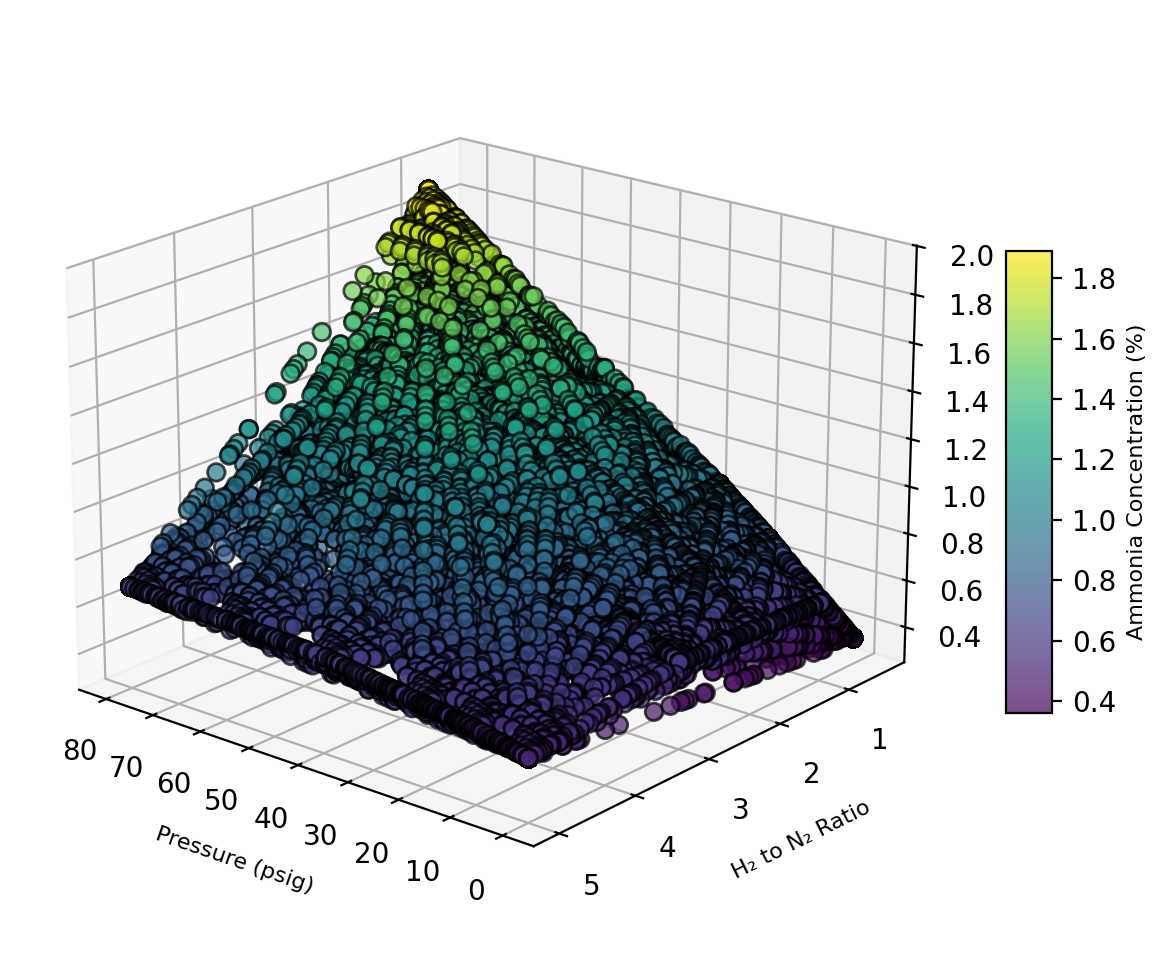

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3Dプロットの作成
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 高解像度の設定
fig.dpi = 200  # 解像度を300dpiに設定

# データの散布図（zを色としてカラーマップを設定）
sc = ax.scatter(
    pressure,  # x軸データ
    ratio,     # y軸データ
    concentration,  # z軸データ
    c=concentration,  # カラーマップに従って色を変える
    cmap='viridis',  # カラーマップをViridisに設定
    marker='o',
    s=40,
    edgecolors='k',
    alpha=0.7
)

# 軸ラベルとフォントサイズ
ax.set_xlabel('Pressure (psig)', fontsize=8, labelpad=6)
ax.set_ylabel('H₂ to N₂ Ratio', fontsize=8, labelpad=6)
ax.set_zlabel('Ammonia Concentration (%)', fontsize=8, labelpad=6)


# 視点の調整（角度）
ax.view_init(elev=20, azim=130)

# 軸目盛のフォントサイズ
ax.tick_params(axis='both', which='major', labelsize=10)

# カラーバーの追加
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Ammonia Concentration (%)', fontsize=8)

# グリッドの調整
ax.grid(True)

# 図の表示
plt.show()

### 3.2 3D散布図を作成（2）
Plotlyによるオーバーサンプリングの分布図

In [13]:
# 3D散布図の生成
fig = go.Figure(data=go.Scatter3d(
    x = pressure,
    y = ratio,
    z = concentration,
    mode='markers',
    marker=dict(
        size=5,  # サイズを少し小さめに調整
        color = concentration,
        colorscale='Viridis',
        colorbar=dict(title='Ammonia Concentration (%)', titleside='right', titlefont=dict(size=14)),
        opacity=0.7
    )
))

# プロットのタイトルと軸ラベル、フォントサイズ、レイアウトを設定
fig.update_layout(
    title=dict(
        text='3D Scatter Plot of SMOTE Data',
        font=dict(size=16),
        x=0.5  # タイトルを中央揃え
    ),
    scene=dict(
        xaxis=dict(
            title=dict(text='Pressure (psig)', font=dict(size=12)),
            tickfont=dict(size=10)
        ),
        yaxis=dict(
            title=dict(text='H₂ to N₂ Ratio', font=dict(size=12)),
            tickfont=dict(size=10)
        ),
        zaxis=dict(
            title=dict(text='Ammonia Concentration (%)', font=dict(size=12)),
            tickfont=dict(size=10)
        )
    ),
    margin=dict(l=0, r=0, b=0, t=50)  # マージンを調整し余白を少なく
)

fig.update_layout(width=800, height=600, 
                  showlegend=False
                  )  # 凡例を非表示に設定

# プロット表示
fig.show()
